## Import libraries 📚

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!pip install bayesian-optimization
!pip install fastai==2.6.3
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=a0bb387a2aa2aa896fa55472ba8e52c25d83d1b7f6a297abd2ad974c643c8578
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.1 MB/s 
     |████████████████████████████████| 61 kB 8.3 MB/s 
     |████████████████████████████████| 750.6 MB 9.4 kB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Suc

In [ ]:
from tsai.all import *
my_setup()

os             : Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.13
tsai           : 0.3.1
fastai         : 2.6.3
fastcore       : 1.4.5
torch          : 1.11.0+cu102
device         : 1 gpu (['Tesla T4'])
cpu cores      : 2
RAM            : 12.68 GB
GPU memory     : [14.75] GB


In [ ]:
from tsai.data.tabular import *
from tsai.data.mixed import get_mixed_dls
from tsai.models.utils import *
from tsai.models.TabModel import *
from sklearn.cluster import SpectralCoclustering

In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


## Prepare data 🔢

We are going to select a dataset from the recently released Monash, UEA & UCR 
Time Series Extrinsic Regression Repository (2020) ([web](http://tseregression.org), [paper](https://arxiv.org/abs/2006.10996)). 

Please, feel free to select any other dataset to experiment with it. Here's the entire list.

In [ ]:
import pandas as pd
import pickle
import sklearn.metrics as skm
import numpy as np
data_folder = '/drive/My Drive/boulot/napoleon/'
x_train = pd.read_csv(data_folder + 'input_train__fppJZ22.csv')
y_train = pd.read_csv(data_folder + 'y_train_CGZ7jXu.csv')
x_test = pd.read_csv(data_folder + 'input_test__2scdXsn.csv')
y_test_rand = pd.read_csv(data_folder + 'y_rand.csv')
with open(data_folder + "adjacency_matrices_pgWTvf5.pkl", "rb") as file:
    adj = pickle.load(file)
for k, v in adj.items():
  for i, _ in enumerate(adj[k]):
    adj[k][i][i] = 1

In [ ]:
create = False
if create:
  l = []
  for i in adj.keys():
    df = (pd.Series(SpectralCoclustering(n_clusters=2,
                  random_state=0).fit(adj[i]).row_labels_)
          .reset_index().rename(columns={'index': 'asset', 0:'sub_cluster'}))
    df['cluster'] = i
    l.append(df)
  adj_clusters = pd.concat(l)
  adj_clusters.to_parquet(data_folder + 'adj_clusters.parquet')
else:
  adj_clusters = pd.read_parquet(data_folder + 'adj_clusters.parquet')
ratios = adj_clusters.groupby('cluster').sub_cluster.value_counts(normalize=True).rename('ratio').reset_index()

In [ ]:
ret_cols = ['ret_' + str(i) for i in range(1, 24)]
def fill_na_x(x):
    print(x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    x_transpose = x.transpose()
    x_transpose.loc[ret_cols] = x_transpose.loc[ret_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
    x = x_transpose.transpose()
    clusters_bc_median = x.groupby('cluster').bc.median().to_dict()
    def fill_na_bc(group):
        group['bc'] = group['bc'].fillna(clusters_bc_median[group.name])
        return group
    x = x.groupby(['cluster']).apply(fill_na_bc).reset_index(drop=True)
    assert not x.isna().any(axis=None)
    return x

x_train = fill_na_x(x_train)
x_test = fill_na_x(x_test)

0.04238993512827366
0.04174511018066391


In [ ]:
n_features = 4
def make_X_ts(x, phase):
  x = x.merge(adj_clusters, how='left', on=['cluster', 'asset'], validate='many_to_one')
  x1 = x.groupby(['cluster', 'sub_cluster', 'day'])[ret_cols].median()
  x1 = x1.reset_index().merge(ratios, how='left', on=['cluster', 'sub_cluster'], validate='many_to_one')
  for c in ret_cols:
    x1[c] = x1[c] * x1['ratio']
  x1.drop(columns='ratio', inplace=True)
  x1.set_index(['cluster', 'sub_cluster', 'day'], inplace=True)

  x1['feat'] = 'median'
  x2 = x1.copy()
  x2.reset_index()
  x2.sort_values(['cluster', 'sub_cluster', 'day'], inplace=True)
  x2 = x2.groupby(['cluster', 'sub_cluster']).shift(-1).fillna(method='ffill')
  x2 = x2.reset_index().set_index(['cluster', 'sub_cluster', 'day'])
  x2['feat'] = 'median_next'
  x = pd.concat([
                  x1,
                  #x1b, 
                  x2,
                  #x2b, 
                  #x3
                  ]).sort_index()
  x.reset_index(inplace=True)
  x.sort_values(['cluster', 'day', 'sub_cluster', 'feat'], inplace=True)
  x.drop(columns='feat', inplace=True)
  n_samples = x.groupby(['cluster', 'day']).ngroups
  x = x[ret_cols].values.reshape((n_samples, n_features, 23))

  X = np.memmap(data_folder + 'x_' + phase + '.dat', dtype='float32', mode='w+', shape=(n_samples, n_features, 23))
  X[:] = x[:]
  print(X.shape)
  return X

In [ ]:
n_features = 1
def make_X_ts(x, phase):
  #x = x.groupby(['cluster', 'day'])[ret_cols].mean()#.quantile([0.05, 0.25, 0.5, 0.75, 0.95])
  x1 = x.groupby(['cluster', 'day'])[ret_cols].median()
  #x1['feat'] = 'median'
  #x1b = x.groupby(['cluster', 'day'])[ret_cols].mean()
  #x1b['feat'] = 'mean'
  x2 = x1.copy()
  x2.reset_index()
  x2.sort_values(['cluster', 'day'], inplace=True)
  x2 = x2.groupby('cluster').shift(-1).fillna(method='ffill')
  x2 = x2.reset_index().set_index(['cluster', 'day'])
  x2.columns = ['ret_' + str(int(c.strip('ret_')) + 24) for c in ret_cols]
  #x2.feat = 'median_next_rev'
  #x2b = x1.copy()
  #x2b.reset_index()
  #x2b.sort_values(['cluster', 'day'], inplace=True)
  #x2b = x2b.groupby('cluster').shift(-1).fillna(method='ffill')
  #x2b = x2b.reset_index().set_index(['cluster', 'day'])
  #x2b.columns = ['ret_' + str(-1 * int(c.strip('ret_')) + 24) for c in ret_cols] + ['feat']
  #x2b.feat = 'mean_next_rev'
  #x2 = x.groupby(['cluster', 'day'])[ret_cols].std()
  #x2['feat'] = 'std'
  #x3 = pd.DataFrame(dict({c: x.groupby(['cluster', 'day']).bc.mean() for c in ret_cols}, **{'feat': 'bc'}))
  x = pd.concat([
                 x1,
                 #x1b, 
                 x2,
                 #x2b, 
                 #x3
                 ], axis=1).sort_index()
  print(x.shape)
  x.reset_index(inplace=True)
  x.sort_values(['cluster', 'day'], inplace=True)
  #x.drop(columns='feat', inplace=True)
  n_samples = x.groupby(['cluster', 'day']).ngroups
  x = x[x1.columns.tolist() + x2.columns.tolist()].values.reshape((n_samples, n_features, 2 * 23))

  X = np.memmap(data_folder + 'x_' + phase + '.dat', dtype='float32', mode='w+', shape=(n_samples, n_features, 2 * 23))
  X[:] = x[:]
  print(X.shape)
  return X

In [ ]:
def make_X_tab(x, y, phase):
  x = x.copy()
  x.sort_values(['cluster', 'day'], inplace=True)
  X = x.groupby(['cluster', 'day'])['md', 'bc'].agg(['mean'])
  X.reset_index(inplace=True)
  if phase == 'train':
    y = y.copy()
    y.sort_values('sample_id', inplace=True)
    X['target'] = y['target'].values
  X.columns = ['_'.join(column) for column in X.columns.to_flat_index()]
  print(X.shape)
  return X

In [ ]:
X_ts = make_X_ts(x_train, 'train')
X_ts_test = make_X_ts(x_test, 'test')

X_tab = make_X_tab(x_train, y_train, 'train')
X_tab_test = make_X_tab(x_test, None, 'test')

y_train.sort_values('sample_id', inplace=True)
y_train = y_train.values[:, 1]
y = np.memmap(data_folder + 'y_train.dat', dtype='float32', mode='w+', shape=(30494,))
y[:] = y_train[:]

(30494, 46)
(30494, 1, 46)
(13133, 46)
(13133, 1, 46)
(30494, 5)
(13133, 4)


X      - shape: [30494 samples x 1 features x 46 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (30494,)  type: memmap  dtype:float32  isnan: 0
splits - n_splits: 2 shape: [20000, 10494]  overlap: False


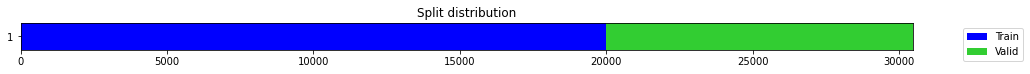

In [ ]:
splits = (L(range(20000)), L(range(20000, 30494)))
check_data(X_ts, y, splits)
bs = 128
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls_ts = get_ts_dls(X_ts, y, splits=splits, tfms=tfms, 
                 #batch_tfms=batch_tfms, 
                 bs=bs)
dls_tab = get_tabular_dls(X_tab, procs=[], cat_names=[], cont_names=['md_mean',
                                                                     #'md_std',
                                                                     'bc_mean',
                                                                     #'bc_std', 
                                                                     #'cluster_'
                                                                     ],
                          y_names='target_', splits=splits, bs=bs)

`TSDatasets` identifies this as a regression problem, as the 2nd output (the ys) are floats. That's why the number of classes is set to 1. This is required to be able to correctly use the time series models available in `timesereisAI`.

In [ ]:
dls = get_mixed_dls(dls_ts, dls_tab, bs=bs)

In [ ]:
dls.c

1

In [ ]:
seed= 28

## Build learner 🏗

###MultiModal

In [ ]:
from bayes_opt import BayesianOptimization

def build_multi_learn(nf = 32, depth=6, ks=12, c_out_ict=5, n_out_tab=2, lyrs_tab_n=2,
            lyrs_tab_v=20, lin_ftrs_n=3, lin_ftrs_v=20, conv_dropout=0.,
            fc_dropout_multi=0., fc_dropout_ict=0., bn=True, bottleneck=True, verbose=False, **kwargs):
  random_seed(seed, True)
  lyrs_tab = [lyrs_tab_v for i in range(lyrs_tab_n)]
  lin_ftrs = [lin_ftrs_v for i in range(lin_ftrs_n)]
  ts_model = build_ts_model(InceptionTimePlus, dls=dls_ts, c_in=n_features, c_out=c_out_ict,
                            arch_config=dict(nf=nf, depth=depth, fc_dropout=fc_dropout_ict, bn=bn, conv_dropout=conv_dropout, 
                                            ks=ks, bottleneck=bottleneck))
  
  tab_model = build_tabular_model(TabModel, n_out= n_out_tab, layers=lyrs_tab, dls=dls_tab, arch_config=dict(skip=True))
  
  MultiModalNet = MultiInputNet(ts_model, tab_model, c_out=1, lin_ftrs=lin_ftrs, fc_dropout=fc_dropout_multi)
  learn = Learner(dls, MultiModalNet, metrics=[mae, rmse])
  if verbose:
    print(count_parameters(ts_model))
    print(count_parameters(tab_model))
    print(count_parameters(learn.model))
  return learn

def best_lr(**kwargs):
  learn = build_multi_learn(**kwargs)
  lr = learn.lr_find(start_lr=1e-5, end_lr=100, stop_div=True, show_plot=False)
  return lr.valley

def run_cycle(lr=1e-3, n_epoch=50, **kwargs):
  learn = build_multi_learn(**kwargs)
  learn.fit_one_cycle(n_epoch, lr)
  return learn.final_record[-1], learn

def f(**kwargs):
  for k, v in kwargs.items():
    kwargs[k] = int(v)
  kwargs['bn'] = bool(kwargs['bn'])
  lr = best_lr(**kwargs)
  return run_cycle(lr=lr, **kwargs)[0]

In [ ]:
# Bounded region of parameter space
pbounds = {'nf': (50, 100), 
           'depth': (4, 12),
           'ks': (18, 36),
           'c_out_ict': (5, 21), 
           'n_out_tab': (2, 7), 
           'lyrs_tab_n': (2, 7), 
           'lyrs_tab_v': (10, 80), 
           'lin_ftrs_n': (2, 6),
           'lin_ftrs_v': (10, 80), 
           'conv_dropout': (0., 0.4), 
           'fc_dropout_multi': (0., 0.5),
           'fc_dropout_ict': (0, 0.5), 
           'bn': (0, 2), 
           'n_epoch': (50, 90)
           }

optimizer = BayesianOptimization(
    f=f,
    pbounds=pbounds,
    random_state=1,
)
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
logger = JSONLogger(path=data_folder + f"logs{str(pd.Timestamp.now()).replace('.', '-').replace(':', '-')}.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    init_points=3,
    n_iter=100,
)
print(optimizer.max)

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000320,0.000195,0.008922,0.013976,00:12
1,0.000156,0.000131,0.008065,0.011465,00:12
2,0.000122,0.000148,0.008040,0.012175,00:12
3,0.000102,0.000103,0.006772,0.010143,00:12
4,0.000096,0.000098,0.006828,0.009903,00:12
5,0.000080,0.000110,0.006941,0.010477,00:12
6,0.000081,0.000135,0.007371,0.011622,00:12
7,0.000067,0.000099,0.006632,0.009964,00:12
8,0.000062,0.000127,0.007253,0.011268,00:12
9,0.000063,0.000128,0.007054,0.011312,00:12


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.001621,0.000161,0.008953,0.012685,00:12
1,0.000180,0.000108,0.006977,0.010400,00:12
2,0.000097,0.000096,0.006844,0.009791,00:12
3,0.000075,0.000084,0.006415,0.009176,00:12
4,0.000069,0.000132,0.008273,0.011479,00:12
5,0.000070,0.000167,0.008438,0.012904,00:12
6,0.000064,0.000278,0.011887,0.016671,00:12
7,0.000054,0.000288,0.012705,0.016977,00:12
8,0.000049,0.000381,0.014941,0.019528,00:12
9,0.000048,0.000326,0.013314,0.018049,00:12


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000172,0.000145,0.007513,0.012051,00:15
1,0.000140,0.000151,0.007487,0.012278,00:14
2,0.000144,0.000163,0.008135,0.012752,00:14
3,0.000137,0.000144,0.007260,0.012008,00:14
4,0.000136,0.000152,0.007432,0.012317,00:14
5,0.000132,0.000147,0.007458,0.012122,00:14
6,0.000137,0.000149,0.007688,0.012206,00:15
7,0.000140,0.000147,0.007450,0.012108,00:14
8,0.000146,0.000173,0.009240,0.013153,00:14
9,0.000145,0.000149,0.007417,0.012215,00:14


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000148,0.000119,0.007905,0.010930,00:20
1,0.000080,0.000091,0.006752,0.009541,00:20
2,0.000060,0.000082,0.006340,0.009053,00:20
3,0.000049,0.000074,0.006016,0.008601,00:20
4,0.000050,0.000068,0.005731,0.008256,00:20
5,0.000061,0.000096,0.006913,0.009812,00:20
6,0.000048,0.000083,0.006139,0.009089,00:20
7,0.000052,0.000084,0.006614,0.009144,00:20
8,0.000042,0.000064,0.005509,0.007984,00:20
9,0.000039,0.000073,0.005808,0.008530,00:20


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000122,0.000119,0.007095,0.010898,00:10
1,0.000100,0.000096,0.006764,0.009780,00:10
2,0.000081,0.000165,0.008453,0.012831,00:10
3,0.000073,0.000137,0.007110,0.011685,00:10
4,0.000071,0.000084,0.006231,0.009184,00:10
5,0.000067,0.000080,0.005937,0.008959,00:10
6,0.000059,0.000112,0.007823,0.010605,00:10
7,0.000047,0.000110,0.007655,0.010493,00:10
8,0.000039,0.000090,0.007115,0.009467,00:10
9,0.000037,0.000060,0.005161,0.007732,00:10


KeyboardInterrupt: ignored

In [ ]:
str(pd.Timestamp.now()).replace('.', '-').replace(':', '-')

'2022-08-06 09:24:41-923378'

In [ ]:
kwargs = {"bn": 1.500288629889935,
          "c_out_ict": 10.910888711251957,
          "conv_dropout": 0.29926626175193577,
          "depth": 6.963107944450837,
          "fc_dropout_ict": 0.23678379853544654,
          "fc_dropout_multi": 0.030967801973292606,
          "ks": 17.374722314110862,
          "lin_ftrs_n": 5.634382012372383,
          "lin_ftrs_v": 30.552990386157564,
          "lyrs_tab_n": 3.4388766929317436,
          "lyrs_tab_v": 19.102000048279436,
          "n_out_tab": 2.0968347893514854,
          "nf": 235.7671065879782,
          'n_epoch':50}
#for k, v in kwargs.items():
#  kwargs[k] = int(v)
#kwargs['bn'] = bool(kwargs['bn'])
#build_multi_learn(verbose=True, **kwargs)
_, learn = f(**kwargs, verbose=True)

11183180
890
11216111


11183180
890
11216111


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000145,0.000135,0.007227,0.011602,00:29
1,0.000113,0.000115,0.007196,0.010716,00:29
2,0.000112,0.000130,0.007115,0.011390,00:30
3,0.000100,0.000095,0.006670,0.009756,00:30
4,0.000100,0.000125,0.007206,0.011183,00:30
5,0.000083,0.000098,0.006569,0.009910,00:30
6,0.000075,0.000158,0.008023,0.012588,00:30
7,0.000067,0.000069,0.005723,0.008332,00:30
8,0.000057,0.000104,0.006951,0.010195,00:30
9,0.000056,0.000164,0.008475,0.012823,00:30


Full train

In [ ]:
splits_full = (L(range(30493)), L(range(20000, 30494)))
dls_ts = get_ts_dls(X_ts, y, splits=splits_full, tfms=tfms, bs=bs)
dls_tab = get_tabular_dls(X_tab, procs=[], cat_names=[], cont_names=['md_mean', 'bc_mean'],
                          y_names='target_', splits=splits_full, bs=bs)
dls = get_mixed_dls(dls_ts, dls_tab, bs=bs)

In [ ]:

for k, v in kwargs.items():
  kwargs[k] = int(v)
kwargs['bn'] = bool(kwargs['bn'])
lr = best_lr(**kwargs)

In [ ]:
_, learn = run_cycle(lr=lr, **kwargs)

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000115,0.000094,0.006714,0.009718,00:23
1,0.000072,0.000067,0.005810,0.008182,00:23
2,0.000058,0.000046,0.004674,0.006751,00:24
3,0.000047,0.000052,0.004977,0.007242,00:23
4,0.000042,0.000045,0.004634,0.006673,00:22
5,0.000035,0.000036,0.004250,0.006024,00:22
6,0.000033,0.000056,0.005433,0.007458,00:22
7,0.000038,0.000036,0.004166,0.005973,00:22
8,0.000031,0.000025,0.003441,0.004969,00:22
9,0.000022,0.000029,0.003476,0.005395,00:22


In [ ]:
dls_ts = get_ts_dls(X_ts_test, None, splits=None, tfms=tfms, 
                 #batch_tfms=batch_tfms, 
                 bs=bs, drop_last=False, shuffle_train=False)
dls_tab = get_tabular_dls(X_tab_test, procs=[], cat_names=[], cont_names=['md_mean', 'bc_mean'],
                          y_names=None, splits=None, bs=bs, drop_last=False, shuffle_train=False)
dls = get_mixed_dls(dls_ts, dls_tab, bs=bs, shuffle_train=False)

In [ ]:
l = []
for b in dls.train:
  l.extend(list(to_np(learn.model(b[0])).flatten()))
pd.DataFrame({'sample_id':y_test_rand.sample_id, 'target':l}
             ).to_csv(data_folder + 'y_test_5787.csv', index=False, )

In [ ]:
l

[-0.007015014,
 -0.00938903,
 -0.0041021537,
 -0.006495828,
 0.000713598,
 -0.0022318605,
 0.00065343827,
 -0.014968501,
 -0.012292353,
 0.0077448487,
 0.0023169294,
 -0.0035678186,
 -8.040108e-05,
 0.000120727345,
 0.0014604945,
 0.0043943934,
 -0.0018948168,
 0.0039697886,
 -0.016314035,
 -0.003690714,
 0.01915558,
 -0.006188942,
 -0.004079163,
 0.009613527,
 -0.009247491,
 0.0068644434,
 0.007585464,
 0.0014780201,
 -0.0060405303,
 -0.018945074,
 0.008789752,
 0.010510933,
 0.0026515909,
 -0.00020414963,
 0.0027409457,
 -0.0093295295,
 0.009338573,
 0.014288642,
 -0.0110698845,
 -0.029395914,
 0.0018089507,
 0.006401174,
 0.0054549985,
 -0.004937278,
 0.0063403156,
 0.001709098,
 0.010085689,
 0.01863395,
 0.004691599,
 0.013223297,
 -0.010764705,
 0.001649024,
 0.009607676,
 0.010654566,
 0.0073889643,
 -0.0071768407,
 -0.015623843,
 -0.009555375,
 -0.005098844,
 -0.00051393174,
 0.0021630637,
 -0.0014659222,
 0.011444049,
 0.015789706,
 0.01633621,
 1.004152e-05,
 -0.021502586,
 -

###InceptionTimePlus

300801


SuggestedLRs(valley=0.001737800776027143)

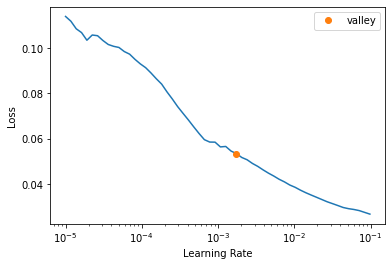

In [ ]:
random_seed(seed, True)
learn = ts_learner(dls_ts, InceptionTimePlus(c_in=n_features, c_out=1, nf=nf, depth=depth), metrics=[mae, rmse], cbs=ShowGraph())
print(count_parameters(learn.model))
learn.lr_find(start_lr=1e-5, end_lr=100, stop_div=True)

In [ ]:
learn.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.002056,0.000456,0.014834,0.021346,00:03
1,0.000500,0.001562,0.025311,0.039526,00:03
2,0.000461,0.001441,0.024633,0.037962,00:03
3,0.000308,0.000356,0.014321,0.018874,00:03
4,0.000189,0.000147,0.008217,0.012134,00:03
5,0.000199,0.000191,0.009642,0.013818,00:03
6,0.000160,0.000291,0.008841,0.017067,00:03
7,0.000169,0.000085,0.006373,0.009202,00:03
8,0.000183,0.000288,0.009224,0.016972,00:04
9,0.000198,0.000229,0.013232,0.015126,00:03


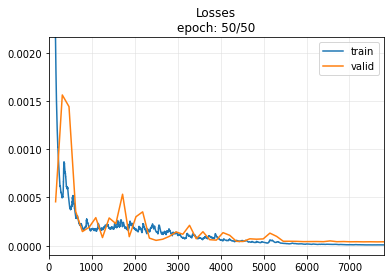

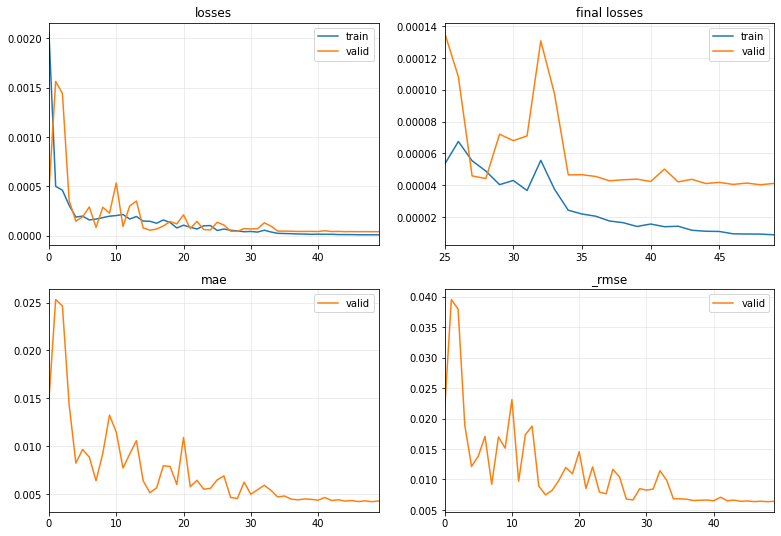

In [ ]:
lr = 3e-3
random_seed(seed, True)
learn = ts_learner(dls_ts, InceptionTime(c_in=n_features, c_out=1, nf=nf, depth=depth), metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(50, lr)

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.000011,0.000042,0.004311,0.006478,00:03
1,0.000015,0.000050,0.004592,0.007093,00:03
2,0.000014,0.000049,0.004713,0.007022,00:03
3,0.000015,0.000043,0.004419,0.006565,00:03
4,0.000019,0.000050,0.005043,0.007050,00:03
5,0.000037,0.000046,0.004535,0.006792,00:03
6,0.000044,0.000071,0.005140,0.008452,00:03
7,0.000047,0.000055,0.004866,0.007405,00:03
8,0.000054,0.000057,0.005365,0.007520,00:03
9,0.000151,0.000577,0.021498,0.024028,00:03


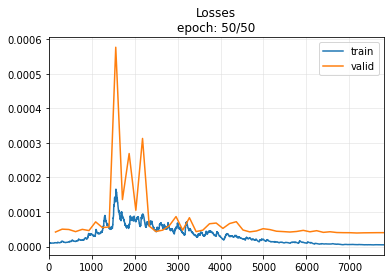

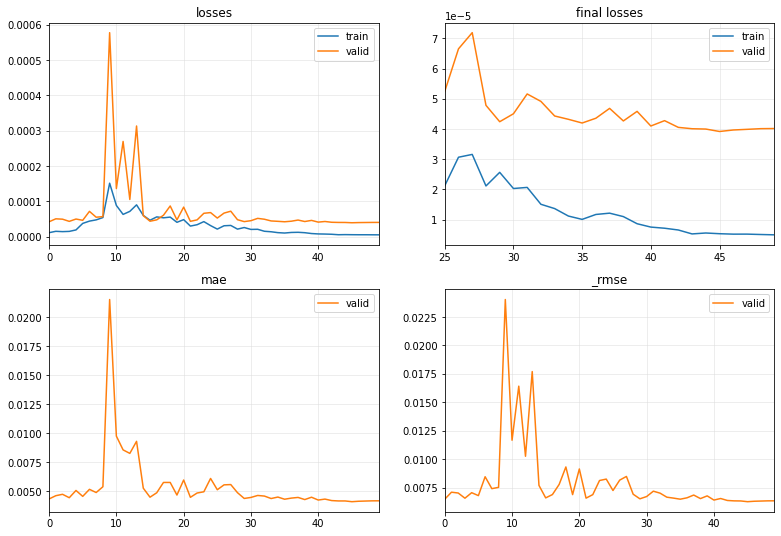

In [ ]:
learn.fit_one_cycle(50, lr)

In [ ]:
random_seed(seed, True)
splits_full = (L(range(30493)), L(range(20000, 30494)))
dls_ts_full = get_ts_dls(X_ts, y, splits=splits_full, tfms=tfms, 
                 #batch_tfms=batch_tfms, 
                 bs=bs)
learn = ts_learner(dls_ts_full, InceptionTime(c_in=n_features, c_out=1, nf=nf, depth=depth), #metrics=[mae, rmse], cbs=ShowGraph()
)
learn.fit_one_cycle(50, lr)
learn.fit_one_cycle(46, lr)

epoch,train_loss,valid_loss,time
0,0.000587,0.000426,00:05
1,0.000571,0.000618,00:04
2,0.000359,0.000601,00:04
3,0.000253,0.000122,00:04
4,0.000177,0.000189,00:05
5,0.000114,0.000104,00:04
6,0.000111,0.000113,00:04
7,0.000144,0.000074,00:04
8,0.000157,0.000200,00:04
9,0.000144,0.000117,00:04


epoch,train_loss,valid_loss,time
0,0.000007,0.000005,00:04
1,0.000008,0.000005,00:04
2,0.000010,0.000005,00:06
3,0.000012,0.000011,00:04
4,0.000012,0.000014,00:04
5,0.000027,0.000049,00:04
6,0.000019,0.000030,00:04
7,0.000044,0.000108,00:04
8,0.000036,0.000044,00:04
9,0.000033,0.000025,00:06


In [ ]:
PATH = Path('./models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [ ]:
del learn

## Inference ⎘

We'll now upload the saved learner and create the predictions:

In [ ]:
PATH = Path('./models/Regression.pkl')
learn = load_learner(PATH, cpu=False)

In [ ]:
probas, _, preds = learn.get_X_preds(X_ts[splits[1]])
skm.mean_squared_error(y[splits[1]], preds, squared=False)

0.001226347761871795

In [ ]:
skm.mean_squared_error(y[splits[1]], [0] * len(splits[1]), squared=False)

0.012084076789480166

As you can see, this matches the valid rmse at the end of training, so the model is predicting correctly. Now you can pass any data and generate other predictions.

In [ ]:
probas, _, preds = learn.get_X_preds(X_ts_test)
pd.DataFrame({'sample_id':y_test_rand.sample_id, 'target':[p[0] for p in preds]}
             ).to_csv(data_folder + 'y_test_6259b.csv', index=False, )

In [ ]:
pd.DataFrame({'sample_id':y_test_rand.sample_id, 'target':0}
             ).to_csv(data_folder + 'y_test_noob.csv', index=False, )

## Summary ✅

As you can see, to use fastai and timeseriesAI to perform a time series regression/ forecasting task is pretty easy. The only thing you need to make sure is that:

* Your data is correctly prepared (with ys as floats)
* Select the right metrics (Learner will automatically select the right loss, unless you want to pass a specific one yourself).